In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
print(X.iloc[0, :])
print(y[:10])

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64
0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


In [6]:
y = y.astype(np.uint8)

In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [8]:
enc.fit(y[:,np.newaxis])

<ipython-input-8-78fc683d5810>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  enc.fit(y[:,np.newaxis])


OneHotEncoder()

In [9]:
Y = enc.transform(y[:,np.newaxis]).toarray()

<ipython-input-9-fd377ab0d802>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = enc.transform(y[:,np.newaxis]).toarray()


In [10]:
Y.shape

(70000, 10)

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [12]:
X_train = X_train / 255
X_test = X_test / 255

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [14]:
def softmax(X, W):
    K = np.size(W, 1)
    A = np.exp(X @ W)
    B = np.diag(1 / (np.reshape(A @ np.ones((K,1)), -1)))
    Y = B @ A
    return Y

In [15]:
# add L2 regularization
def compute_cost(X, T, W, lambda_):
    epsilon = 1e-5
    N = len(T)
    K = np.size(T, 1)
    cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1)) + 1 / 2 * lambda_ * np.sum(W ** 2)
    return cost

In [16]:
def predict(X, W):
    return np.argmax((X @ W), axis=1)

In [17]:
def batch_gd(X, T, W, learning_rate, iterations, batch_size, lambda_):
    N = len(T)
    cost_history = np.zeros((iterations,1))
    shuffled_indices = np.random.permutation(N)
    X_shuffled = X[shuffled_indices]
    T_shuffled = T[shuffled_indices]

    for i in range(iterations):
        j = i % N
        X_batch = X_shuffled[j:j+batch_size]
        T_batch = T_shuffled[j:j+batch_size]
        # batch가 epoch 경계를 넘어가는 경우, 앞 부분으로 채워줌
        if X_batch.shape[0] < batch_size:
            X_batch = np.vstack((X_batch, X_shuffled[:(batch_size - X_batch.shape[0])]))
            T_batch = np.vstack((T_batch, T_shuffled[:(batch_size - T_batch.shape[0])]))
        W = W - (learning_rate/batch_size) * (X_batch.T @ (softmax(X_batch, W) - T_batch))
        cost_history[i] = compute_cost(X_batch, T_batch, W, lambda_)
        if i % 1000 == 0:
            print(f'{i}번째 loss값: {cost_history[i][0]}')

    return (cost_history, W)

In [19]:
X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train))
T = y_train

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

iterations = 50000
learning_rate = 0.01

initial_cost = compute_cost(X, T, W, 0)

print("Initial Cost is: {} \n".format(initial_cost[0][0]))

scores = []
lambda_list = [-0.1, -0.01, -0.001, -0.0001, -0.00001, 0, 0.00001, 0.0001, 0.001, 0.01, 0.1]

for lambda_ in lambda_list:
  (cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64, lambda_)
  y_pred = predict(X, W_optimal)
  score = float(sum(y_pred == np.argmax(T, axis=1)))/ float(len(y_pred))
  scores.append(score)

Initial Cost is: 2.302485097993735 

0번째 loss값: 2.273356113620958
1000번째 loss값: 0.03272103047063302
2000번째 loss값: -0.5559448526721471
3000번째 loss값: -0.8758760193537798
4000번째 loss값: -1.299726469874479
5000번째 loss값: -1.6007479100833046
6000번째 loss값: -1.6336347487580096
7000번째 loss값: -1.7963907981304863
8000번째 loss값: -2.027949694857417
9000번째 loss값: -2.310551568573728
10000번째 loss값: -2.5499766497803042
11000번째 loss값: -2.706946522715215
12000번째 loss값: -2.823221268682097
13000번째 loss값: -2.9456951477801
14000번째 loss값: -3.1799186095876237
15000번째 loss값: -3.267146127625364
16000번째 loss값: -3.276254324175992
17000번째 loss값: -3.2957843563640177
18000번째 loss값: -3.4282003050680987
19000번째 loss값: -3.6999283806000616
20000번째 loss값: -3.42745216201437
21000번째 loss값: -3.7893615664042284
22000번째 loss값: -3.9522519551757913
23000번째 loss값: -3.866068581226835
24000번째 loss값: -4.019202114595645
25000번째 loss값: -4.160311216850454
26000번째 loss값: -4.049322421058251
27000번째 loss값: -4.209218509628587
28000번째 loss값: 

<ipython-input-21-6233d9d53a5e>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lambda_list), scores)
<ipython-input-21-6233d9d53a5e>:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(lambda_list), scores)


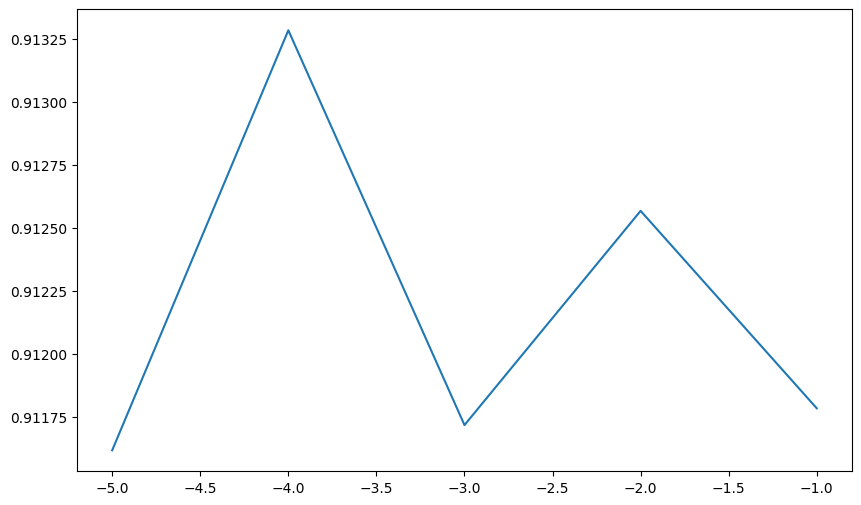

In [21]:
plt.figure(figsize=(10,6))
plt.plot(np.log10(lambda_list), scores)
plt.show()

In [ ]:
## Accuracy
X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
T_ = y_test
y_pred = predict(X_, W_optimal)
score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))

print(score)